## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance

from matplotlib import pyplot

In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [8]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## *Create new features

In [9]:
#เปลี่ยน Customer id เป็น index
df_=df_clv.set_index('customer_id')
df_

,recency,frequency,monetary_value,AOU,ticket_size
customer_id,,,,,
CS1112,62.0,15,1012,1309,67.466667
CS1113,36.0,20,1490,1354,74.500000
CS1114,33.0,19,1432,1309,75.368421
CS1115,12.0,22,1659,1303,75.409091
CS1116,204.0,13,857,1155,65.923077
...,...,...,...,...,...
CS8996,98.0,13,582,1120,44.769231
CS8997,262.0,14,543,1116,38.785714
CS8998,85.0,13,624,1293,48.000000


ข้อมูลที่มีเป็นข้อมูลตั้งแต่ปี 2011 ซึ่งข้อมูลในอดีตอาจมีความสำคัญไม่เท่าข้อมูลในปัจจุบัน หรือ ในปีที่ใหม่กว่า
 - สร้าง features frequency/monetary_value/ticket_size ที่คำนวณโดยใช้ข้อมูลตั้งแต่ปี 2012-2015 จนถึงล่าสุด

In [10]:
## create data set with CLV variables for year 2012
#df_transactions_2012=df_transactions[(df_transactions['trans_date']>="01-01-2012")&(df_transactions['trans_date']<="31-12-2012")]
df_transactions_2012=df_transactions[df_transactions['trans_date']>="01-01-2012"]


df_clv_2012 = df_transactions_2012.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_2012.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv_2012['ticket_size'] = df_clv_2012['monetary_value'] / df_clv_2012['frequency']

df_transactions_2012.head(5)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


In [11]:
## create data set with CLV variables for year 2013
#df_transactions_2013=df_transactions[(df_transactions['trans_date']>="01-01-2013")&(df_transactions['trans_date']<="31-12-2013")]
df_transactions_2013=df_transactions[df_transactions['trans_date']>="01-01-2013"]


df_clv_2013 = df_transactions_2013.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_2013.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv_2013['ticket_size'] = df_clv_2013['monetary_value'] / df_clv_2013['frequency']

df_transactions_2013.head(5)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


In [12]:
## create data set with CLV variables for year 2014
#df_transactions_2014=df_transactions[(df_transactions['trans_date']>="01-01-2014")&(df_transactions['trans_date']<="31-12-2014")]
df_transactions_2014=df_transactions[df_transactions['trans_date']>="01-01-2014"]


df_clv_2014 = df_transactions_2014.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_2014.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv_2014['ticket_size'] = df_clv_2014['monetary_value'] / df_clv_2014['frequency']

df_transactions_2014.head(5)

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
14,CS5552,2014-12-29,78,78.0
15,CS6043,2014-01-15,98,426.0


In [13]:
## create data set with CLV variables for year 2015
df_transactions_2015=df_transactions[df_transactions['trans_date']>="01-01-2015"]

df_clv_2015 = df_transactions_2015.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv_2015.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv_2015['ticket_size'] = df_clv_2015['monetary_value'] / df_clv_2015['frequency']

df_transactions_2015.head(5)

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
7,CS5902,2015-01-30,89,46.0
30,CS2859,2015-02-27,77,18.0
31,CS1512,2015-02-21,71,24.0
41,CS1511,2015-01-13,47,63.0


In [14]:
df_['2012_frequency']=df_clv_2012['frequency']
df_['2012_monetary_value']=df_clv_2012['monetary_value']
df_['2012_ticket_size']=df_clv_2012['ticket_size']


df_['2013_frequency']=df_clv_2013['frequency']
df_['2013_monetary_value']=df_clv_2013['monetary_value']
df_['2013_ticket_size']=df_clv_2013['ticket_size']

df_['2014_frequency']=df_clv_2014['frequency']
df_['2014_monetary_value']=df_clv_2014['monetary_value']
df_['2014_ticket_size']=df_clv_2014['ticket_size']


df_['2015_frequency']=df_clv_2015['frequency']
df_['2015_monetary_value']=df_clv_2015['monetary_value']
df_['2015_ticket_size']=df_clv_2015['ticket_size']

   
    - Max spend
    - Min spend
    - standard deviation of spend
    ของแต่ละ customer

In [15]:
df2_ = df_groupby = df_transactions.groupby(by=['customer_id']).agg(MaxSpend=('tran_amount', 'max'),
                                                                                  MinSpend=('tran_amount', 'min'),
                                                                                  StdSpends=('tran_amount', 'std')
                                                                                  ).reset_index()
df2_=df2_ .sort_values(by=['customer_id'])
df2_=df2_.set_index('customer_id')
df2_.head()          

,MaxSpend,MinSpend,StdSpends
customer_id,,,
CS1112,105,36,19.766012
CS1113,98,36,21.254102
CS1114,105,37,21.341692
CS1115,104,41,18.151896
CS1116,105,40,22.940000


In [16]:
df_['max_spend']=df2_['MaxSpend']
df_['min_spend']=df2_['MinSpend']
df_['std_spend']=df2_['StdSpends']

    - การเปลี่ยนแปลงของขนาด ticket_size เทียบกับข้อมูลที่มีตุดเริ่มต้นการคำนวณจากปีก่อนหน้า

In [17]:
df_['tf_2013/2012']=df_['2013_ticket_size']/df_['2012_ticket_size']
df_['tf_2014/2013']=df_['2014_ticket_size']/df_['2013_ticket_size']
df_['tf_2015/2014']=df_['2015_ticket_size']/df_['2014_ticket_size']

    -สัดส่วนของ frequency และ monetary_value ที่คำนวณได้แต่ละปีเทียบกับ frequency และ monetary_value ตลอดอายุของลูกค้า

In [18]:

df_['2012_%f']=df_['2012_frequency']/df_['frequency']
df_['2012_%monetary_value']=df_['2012_monetary_value']/df_['monetary_value']

df_['2013_%f']=df_['2013_frequency']/df_['frequency']
df_['2013_%monetary_value']=df_['2013_monetary_value']/df_['monetary_value']

df_['2014_%f']=df_['2014_frequency']/df_['frequency']
df_['2014_%monetary_value']=df_['2014_monetary_value']/df_['monetary_value']

df_['2015_%f']=df_['2015_frequency']/df_['frequency']
df_['2015_%monetary_value']=df_['2015_monetary_value']/df_['monetary_value']


In [19]:
#ข้อมูลที่ไม่มี กำหนดให้เป็น 0
df_=df_.fillna(0)
df_

,recency,frequency,monetary_value,AOU,ticket_size,2012_frequency,2012_monetary_value,2012_ticket_size,2013_frequency,2013_monetary_value,...,tf_2014/2013,tf_2015/2014,2012_%f,2012_%monetary_value,2013_%f,2013_%monetary_value,2014_%f,2014_%monetary_value,2015_%f,2015_%monetary_value
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,62.0,15,1012,1309,67.466667,12,800,66.666667,7.0,463.0,...,0.948704,0.621514,0.800000,0.790514,0.466667,0.457510,0.266667,0.248024,0.066667,0.038538
CS1113,36.0,20,1490,1354,74.500000,17,1246,73.294118,12.0,872.0,...,0.876802,1.150972,0.850000,0.836242,0.600000,0.585235,0.350000,0.299329,0.150000,0.147651
CS1114,33.0,19,1432,1309,75.368421,14,1006,71.857143,12.0,856.0,...,1.009346,1.097222,0.736842,0.702514,0.631579,0.597765,0.368421,0.351955,0.052632,0.055168
CS1115,12.0,22,1659,1303,75.409091,19,1398,73.578947,12.0,925.0,...,0.954811,0.747283,0.863636,0.842676,0.545455,0.557565,0.227273,0.221820,0.045455,0.033153
CS1116,204.0,13,857,1155,65.923077,9,622,69.111111,6.0,392.0,...,1.019388,0.000000,0.692308,0.725788,0.461538,0.457410,0.384615,0.388565,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,98.0,13,582,1120,44.769231,11,520,47.272727,8.0,419.0,...,1.069212,0.000000,0.846154,0.893471,0.615385,0.719931,0.461538,0.577320,0.000000,0.000000
CS8997,262.0,14,543,1116,38.785714,12,453,37.750000,8.0,295.0,...,1.138983,0.000000,0.857143,0.834254,0.571429,0.543278,0.142857,0.154696,0.000000,0.000000
CS8998,85.0,13,624,1293,48.000000,11,496,45.090909,6.0,224.0,...,0.870536,0.000000,0.846154,0.794872,0.461538,0.358974,0.307692,0.208333,0.000000,0.000000


In [20]:
res=df_response
res=res.set_index('customer_id')
res

,response
customer_id,
CS1112,0
CS1113,0
CS1114,1
CS1115,1
CS1116,1
...,...
CS8996,0
CS8997,0
CS8998,0


In [21]:
df_['response']=res['response']
df_

,recency,frequency,monetary_value,AOU,ticket_size,2012_frequency,2012_monetary_value,2012_ticket_size,2013_frequency,2013_monetary_value,...,tf_2015/2014,2012_%f,2012_%monetary_value,2013_%f,2013_%monetary_value,2014_%f,2014_%monetary_value,2015_%f,2015_%monetary_value,response
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,62.0,15,1012,1309,67.466667,12,800,66.666667,7.0,463.0,...,0.621514,0.800000,0.790514,0.466667,0.457510,0.266667,0.248024,0.066667,0.038538,0.0
CS1113,36.0,20,1490,1354,74.500000,17,1246,73.294118,12.0,872.0,...,1.150972,0.850000,0.836242,0.600000,0.585235,0.350000,0.299329,0.150000,0.147651,0.0
CS1114,33.0,19,1432,1309,75.368421,14,1006,71.857143,12.0,856.0,...,1.097222,0.736842,0.702514,0.631579,0.597765,0.368421,0.351955,0.052632,0.055168,1.0
CS1115,12.0,22,1659,1303,75.409091,19,1398,73.578947,12.0,925.0,...,0.747283,0.863636,0.842676,0.545455,0.557565,0.227273,0.221820,0.045455,0.033153,1.0
CS1116,204.0,13,857,1155,65.923077,9,622,69.111111,6.0,392.0,...,0.000000,0.692308,0.725788,0.461538,0.457410,0.384615,0.388565,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,98.0,13,582,1120,44.769231,11,520,47.272727,8.0,419.0,...,0.000000,0.846154,0.893471,0.615385,0.719931,0.461538,0.577320,0.000000,0.000000,0.0
CS8997,262.0,14,543,1116,38.785714,12,453,37.750000,8.0,295.0,...,0.000000,0.857143,0.834254,0.571429,0.543278,0.142857,0.154696,0.000000,0.000000,0.0
CS8998,85.0,13,624,1293,48.000000,11,496,45.090909,6.0,224.0,...,0.000000,0.846154,0.794872,0.461538,0.358974,0.307692,0.208333,0.000000,0.000000,0.0


In [22]:
df_=df_[df_['response']==df_['response']]
df_=df_.reset_index()

In [23]:
df_

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,2012_frequency,2012_monetary_value,2012_ticket_size,2013_frequency,...,tf_2015/2014,2012_%f,2012_%monetary_value,2013_%f,2013_%monetary_value,2014_%f,2014_%monetary_value,2015_%f,2015_%monetary_value,response
0,CS1112,62.0,15,1012,1309,67.466667,12,800,66.666667,7.0,...,0.621514,0.800000,0.790514,0.466667,0.457510,0.266667,0.248024,0.066667,0.038538,0.0
1,CS1113,36.0,20,1490,1354,74.500000,17,1246,73.294118,12.0,...,1.150972,0.850000,0.836242,0.600000,0.585235,0.350000,0.299329,0.150000,0.147651,0.0
2,CS1114,33.0,19,1432,1309,75.368421,14,1006,71.857143,12.0,...,1.097222,0.736842,0.702514,0.631579,0.597765,0.368421,0.351955,0.052632,0.055168,1.0
3,CS1115,12.0,22,1659,1303,75.409091,19,1398,73.578947,12.0,...,0.747283,0.863636,0.842676,0.545455,0.557565,0.227273,0.221820,0.045455,0.033153,1.0
4,CS1116,204.0,13,857,1155,65.923077,9,622,69.111111,6.0,...,0.000000,0.692308,0.725788,0.461538,0.457410,0.384615,0.388565,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,98.0,13,582,1120,44.769231,11,520,47.272727,8.0,...,0.000000,0.846154,0.893471,0.615385,0.719931,0.461538,0.577320,0.000000,0.000000,0.0
6880,CS8997,262.0,14,543,1116,38.785714,12,453,37.750000,8.0,...,0.000000,0.857143,0.834254,0.571429,0.543278,0.142857,0.154696,0.000000,0.000000,0.0
6881,CS8998,85.0,13,624,1293,48.000000,11,496,45.090909,6.0,...,0.000000,0.846154,0.794872,0.461538,0.358974,0.307692,0.208333,0.000000,0.000000,0.0
6882,CS8999,258.0,12,383,1073,31.916667,9,227,25.222222,5.0,...,0.000000,0.750000,0.592689,0.416667,0.328982,0.166667,0.109661,0.000000,0.000000,0.0


In [24]:
df_=df_.sample(frac=1)
df_.head(5)

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,2012_frequency,2012_monetary_value,2012_ticket_size,2013_frequency,...,tf_2015/2014,2012_%f,2012_%monetary_value,2013_%f,2013_%monetary_value,2014_%f,2014_%monetary_value,2015_%f,2015_%monetary_value,response
5144,CS7256,214.0,11,362,1085,32.909091,10,337,33.700000,7.0,...,0.000000,0.909091,0.930939,0.636364,0.693370,0.272727,0.284530,0.000000,0.000000,0.0
563,CS1675,39.0,28,2124,1300,75.857143,21,1672,79.619048,17.0,...,0.939739,0.750000,0.787194,0.607143,0.635593,0.357143,0.372411,0.107143,0.104991,0.0
4011,CS5123,400.0,15,1047,831,69.800000,13,927,71.307692,7.0,...,0.000000,0.866667,0.885387,0.466667,0.513849,0.066667,0.089780,0.000000,0.000000,0.0
1991,CS3103,4.0,16,1006,1360,62.875000,13,801,61.615385,10.0,...,0.691824,0.812500,0.796223,0.625000,0.570577,0.312500,0.316103,0.062500,0.043738,0.0
5618,CS7733,131.0,16,570,1124,35.625000,14,452,32.285714,8.0,...,0.000000,0.875000,0.792982,0.500000,0.336842,0.375000,0.277193,0.000000,0.000000,0.0


In [25]:
df_clv = df_clv.sample(frac=1)
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
4634,CS5746,44.0,17,1200,1242,70.588235
4277,CS5389,232.0,18,1232,1108,68.444444
5427,CS7539,26.0,12,528,1317,44.000000
4817,CS5929,39.0,18,1315,1353,73.055556
4557,CS5669,192.0,20,1493,1076,74.650000


## **Calculating response rate**

In [26]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


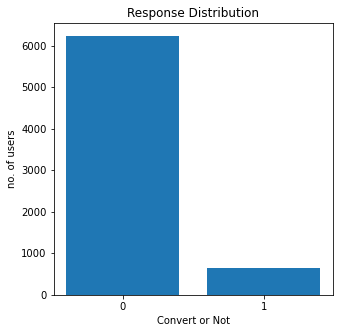

In [27]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [28]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


In [29]:
df_modeling_clv=df_

In [30]:
df_modeling_clv.head(5)

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,2012_frequency,2012_monetary_value,2012_ticket_size,2013_frequency,...,tf_2015/2014,2012_%f,2012_%monetary_value,2013_%f,2013_%monetary_value,2014_%f,2014_%monetary_value,2015_%f,2015_%monetary_value,response
5144,CS7256,214.0,11,362,1085,32.909091,10,337,33.700000,7.0,...,0.000000,0.909091,0.930939,0.636364,0.693370,0.272727,0.284530,0.000000,0.000000,0.0
563,CS1675,39.0,28,2124,1300,75.857143,21,1672,79.619048,17.0,...,0.939739,0.750000,0.787194,0.607143,0.635593,0.357143,0.372411,0.107143,0.104991,0.0
4011,CS5123,400.0,15,1047,831,69.800000,13,927,71.307692,7.0,...,0.000000,0.866667,0.885387,0.466667,0.513849,0.066667,0.089780,0.000000,0.000000,0.0
1991,CS3103,4.0,16,1006,1360,62.875000,13,801,61.615385,10.0,...,0.691824,0.812500,0.796223,0.625000,0.570577,0.312500,0.316103,0.062500,0.043738,0.0
5618,CS7733,131.0,16,570,1124,35.625000,14,452,32.285714,8.0,...,0.000000,0.875000,0.792982,0.500000,0.336842,0.375000,0.277193,0.000000,0.000000,0.0


## **Creating train and test dataset**

*ลองใช้ features ทั้งหมด

In [31]:
df_modeling_clv.columns

Index(['customer_id', 'recency', 'frequency', 'monetary_value', 'AOU',
       'ticket_size', '2012_frequency', '2012_monetary_value',
       '2012_ticket_size', '2013_frequency', '2013_monetary_value',
       '2013_ticket_size', '2014_frequency', '2014_monetary_value',
       '2014_ticket_size', '2015_frequency', '2015_monetary_value',
       '2015_ticket_size', 'max_spend', 'min_spend', 'std_spend',
       'tf_2013/2012', 'tf_2014/2013', 'tf_2015/2014', '2012_%f',
       '2012_%monetary_value', '2013_%f', '2013_%monetary_value', '2014_%f',
       '2014_%monetary_value', '2015_%f', '2015_%monetary_value', 'response'],
      dtype='object')

In [32]:
selected=df_modeling_clv.columns.to_list()
selected.remove('customer_id')
selected.remove('response')

In [33]:
selected

['recency',
 'frequency',
 'monetary_value',
 'AOU',
 'ticket_size',
 '2012_frequency',
 '2012_monetary_value',
 '2012_ticket_size',
 '2013_frequency',
 '2013_monetary_value',
 '2013_ticket_size',
 '2014_frequency',
 '2014_monetary_value',
 '2014_ticket_size',
 '2015_frequency',
 '2015_monetary_value',
 '2015_ticket_size',
 'max_spend',
 'min_spend',
 'std_spend',
 'tf_2013/2012',
 'tf_2014/2013',
 'tf_2015/2014',
 '2012_%f',
 '2012_%monetary_value',
 '2013_%f',
 '2013_%monetary_value',
 '2014_%f',
 '2014_%monetary_value',
 '2015_%f',
 '2015_%monetary_value']

In [34]:
## spliting dataframe into X and y

X_clv = df_modeling_clv[selected]
y_clv = df_modeling_clv['response']

In [35]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

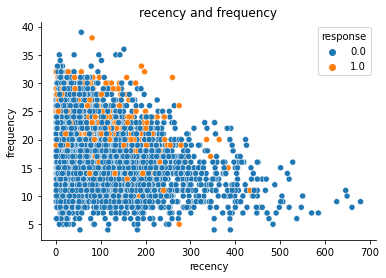

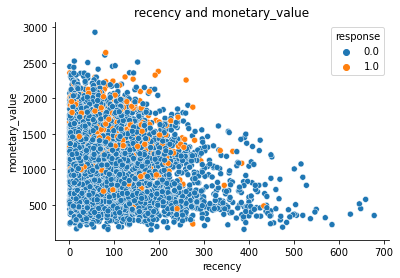

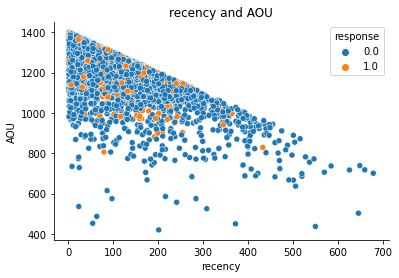

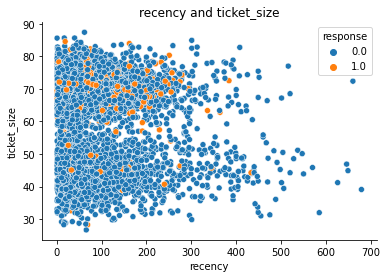

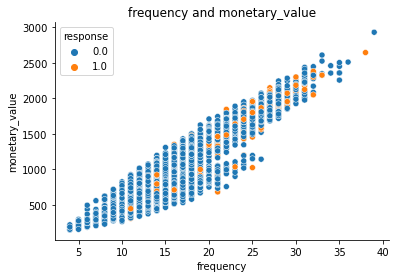

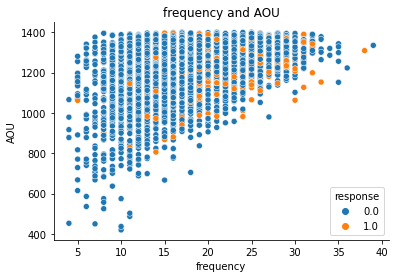

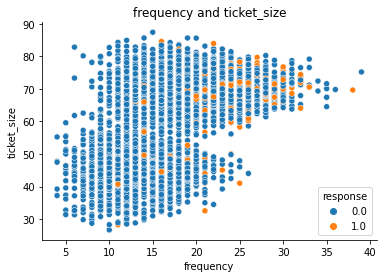

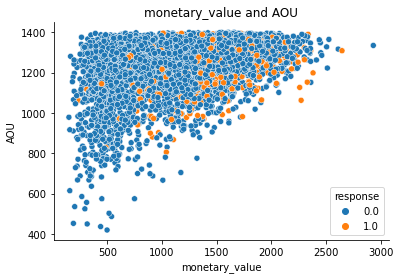

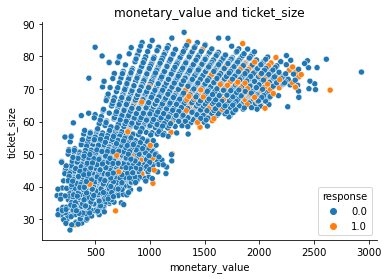

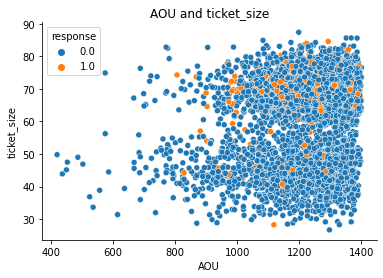

In [36]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
        if i < j :
            plt.title(col_i + ' and ' + col_j)
            sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
            sns.despine()
            plt.show()

## **Fixing imbalanced with SMOTE**

In [37]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [38]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      4350
         1.0       0.78      0.80      0.79      4350

    accuracy                           0.79      8700
   macro avg       0.79      0.79      0.79      8700
weighted avg       0.79      0.79      0.79      8700

test set
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      1887
         1.0       0.17      0.50      0.26       179

    accuracy                           0.75      2066
   macro avg       0.56      0.64      0.55      2066
weighted avg       0.88      0.75      0.80      2066



## **XGBoost**

In [39]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6,importance_type='weight')

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV


C:\Users\Ohm\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.72223
[1]	validation_0-auc:0.73332
[2]	validation_0-auc:0.74622
[3]	validation_0-auc:0.74656
[4]	validation_0-auc:0.75220
[5]	validation_0-auc:0.75016
[6]	validation_0-auc:0.75074
[7]	validation_0-auc:0.75079
[8]	validation_0-auc:0.75092
[9]	validation_0-auc:0.75393
[10]	validation_0-auc:0.75397
[11]	validation_0-auc:0.75174
[12]	validation_0-auc:0.74945
[13]	validation_0-auc:0.74643
[14]	validation_0-auc:0.74604
[15]	validation_0-auc:0.75207
training set
              precision    recall  f1-score   support

         0.0       0.83      0.60      0.69      4350
         1.0       0.68      0.87      0.77      4350

    accuracy                           0.74      8700
   macro avg       0.76      0.74      0.73      8700
weighted avg       0.76      0.74      0.73      8700

test set
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.74      1887
         1.0       0.15      0.75      0.26       179

    accuracy     

*ดูค่า features importance ของแต่ละ features แล้วเลือกเฉพาะ features ที่ weight ไม่เท่ากับ 0 ไปใช่ใน model

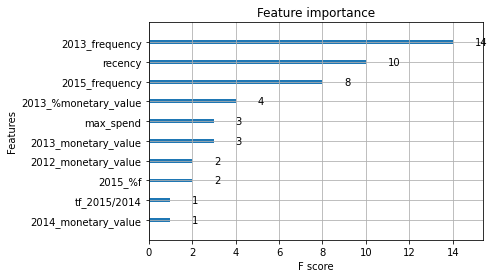

In [40]:
plot_importance(xgb_model_SMOTE_clv)
pyplot.show()

In [41]:
df_importance=pd.DataFrame()

In [42]:
df_importance['features']=selected
df_importance['score']=xgb_model_SMOTE_clv.feature_importances_

In [43]:
df_importance.sort_values(by=['score'],ascending=False)

,features,score
8,2013_frequency,0.291667
0,recency,0.208333
14,2015_frequency,0.166667
26,2013_%monetary_value,0.083333
9,2013_monetary_value,0.062500
17,max_spend,0.062500
6,2012_monetary_value,0.041667
29,2015_%f,0.041667
12,2014_monetary_value,0.020833
22,tf_2015/2014,0.020833


In [44]:
selected_final=df_importance[df_importance['score']>0]['features']

    - fetures ที่ใช้ในการสร้าง model

In [45]:
selected_final.to_list()

['recency',
 '2012_monetary_value',
 '2013_frequency',
 '2013_monetary_value',
 '2014_monetary_value',
 '2015_frequency',
 'max_spend',
 'tf_2015/2014',
 '2013_%monetary_value',
 '2015_%f']

In [46]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [47]:
X_train_clv=X_train_clv[selected_final]
X_test_clv=X_test_clv[selected_final]
X_SMOTE_clv=X_SMOTE_clv[selected_final]

In [48]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.68298
[1]	validation_0-auc:0.69617
[2]	validation_0-auc:0.72218
[3]	validation_0-auc:0.72769
[4]	validation_0-auc:0.73605
[5]	validation_0-auc:0.73493
[6]	validation_0-auc:0.73386
[7]	validation_0-auc:0.73964
[8]	validation_0-auc:0.73746
[9]	validation_0-auc:0.73646
[10]	validation_0-auc:0.73529


C:\Users\Ohm\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-auc:0.73505
training set
              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69      4350
         1.0       0.69      0.87      0.77      4350

    accuracy                           0.74      8700
   macro avg       0.76      0.74      0.73      8700
weighted avg       0.76      0.74      0.73      8700

test set
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.75      1887
         1.0       0.16      0.75      0.26       179

    accuracy                           0.62      2066
   macro avg       0.56      0.68      0.50      2066
weighted avg       0.89      0.62      0.71      2066



In [49]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
 {
    'clf__n_estimators': [300,500,800,1000,1200],
    'clf__learning_rate': [0.01, 0.005,0.001],
    'clf__max_depth': range(1,5),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 4)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2,3,4],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


C:\Users\Ohm\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-

[15:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7528393624815115
[[1195  692]
 [  52  127]]
test set
              precision    recall  f1-score   support

         0.0       0.96      0.63      0.76      1887
         1.0       0.16      0.71      0.25       179

    accuracy                           0.64      2066
   macro avg       0.56      0.67      0.51      2066
weighted avg       0.89      0.64      0.72      2066



In [51]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.1, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 1, 'clf__n_estimators': 1000, 'fs__k': 4, 'fs__score_func': <function chi2 at 0x000001F6C40CF0D8>}


In [52]:
roc=roc_auc_score(y_test_clv, xgb_model_clv_GS.predict_proba(X_test_clv)[:,1])

In [53]:
print('AUC Score (train): {}'.format(xgb_model_clv_GS.best_score_))
print('AUC Score (test): {}'.format(roc))

AUC Score (train): 0.7528393624815115
AUC Score (test): 0.7375722748709933
